In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import scipy.signal as signal
from scipy import interpolate
from scipy.fft import rfft,rfftfreq
from scipy.signal import get_window

In [6]:
#1. Find the largest peak in 1.6-6.7 mHz
#2. Calculate the FWHM of the peak
#3. If FWHM < 2 mHz, calculate the Pc5 inegrated power (S_Pc5) and 
#the spectral power integrated over 0.278-27.8 mHz (S_total).
#4. Calculate the Pc5 index = S_Pc5/S_total.

def narrowband_wave_finder(freqs,psd,fl_s=0.0016,fh_s=0.0067,fl_t=0.000278,fh_t=0.027778):
    """ 
    inputs: 
    freqs: frequencies in Hz (should have the same shape with psd) 
    psd: power spectral density [V**2/Hz] from FFT
    fl_s: lower frequency limit of wave power
    fh_s: higher frequency limit of wave power
    fl_t: lower frequency limit of total power
    fh_t: higher frequency limit of total power
    
    outputs: return None if no event is detected;
    return FWHM, FWHM_left, FWHM_right, peak_psd, peak_freq, S_sig, S_total, I_sig if event detected
    """
    from scipy.signal import find_peaks, peak_widths
    peaks, _ = find_peaks(psd)
    
    peak_f = freqs[peaks]
    peak_psd = psd[peaks]
    sig_ind = np.where((peak_f >= fl_s) & (peak_f <= fh_s))
    
    if sig_ind == []:
        return None
    else:
        peak_sig = peaks[sig_ind]
        peak_psd_sig = peak_psd[sig_ind]
        peak_f_sig = peak_f[sig_ind]
        
        sig_max_ind = np.argmax(peak_psd_sig)
        peak_psd_max = peak_psd_sig[sig_max_ind]
        peak_freq = peak_f_sig[sig_max_ind]*1000.
    
        peak_ind = peak_sig[sig_max_ind]
        #print(peak_ind)
    
        results_half = peak_widths(psd, [peak_ind], rel_height=0.5)
        f_res = freqs[1]-freqs[0]
        FWHM = results_half[0][0]*f_res*1000. #mHz
        if  FWHM >= 2:
            return None
        else:
            psd_sig = psd[(freqs >= fl_s) & (freqs <= fh_s)]
            psd_total = psd[(freqs >= fl_t) & (freqs <= fh_t)]
            S_sig = np.trapz(psd_sig, dx=f_res)
            S_total = np.trapz(psd_total, dx=f_res)
            I_sig = S_sig/S_total
            return FWHM,results_half[2][0],results_half[3][0], peak_psd_max,peak_freq,S_sig,S_total,I_sig

In [2]:
dir_data = 'data/2015Jan/sd.run.1/' #smooth window 15 min
#dir_data = 'data/2015Jan/sd.run.2/'#smooth window 20 min
#dir_data = 'data/2015Jan/sd.run.3/'#smooth window 30 min

date = '2015-01-08'
rad = 'pgr'
time = '0002_1500'
dir_file = dir_data+date+'/'
raw_file = rad+'_'+time+'_raw.csv'
rsamp_file = rad+'_'+time+'_rsamp.csv'
fft_file = rad+'_'+time+'_fft.csv'

In [3]:
#read rsamp file
rsamp_df = pd.read_csv(dir_file+rsamp_file,parse_dates=['time'])
rsamp_df
df1 = rsamp_df[0:200]
test_dt = df1['time']
test_v = df1['v']

In [4]:
#read fft file
fft_df = pd.read_csv(dir_file+fft_file)
fft_df

,frq,v_real,v_imag,amp,ang,bmnum,slist,rad,Tx
0,0.000000,-62.382700,0.000000,62.382700,180.0000,12,34,pgr,1
1,0.000278,33.671000,28.393800,44.044800,40.1399,12,34,pgr,0
2,0.000556,-20.958100,4.367890,21.408500,168.2270,12,34,pgr,0
3,0.000833,6.212590,-39.109200,39.599600,-80.9738,12,34,pgr,0
4,0.001111,17.090600,19.949700,26.269300,49.4139,12,34,pgr,0
...,...,...,...,...,...,...,...,...,...
1207,0.026667,0.381001,-0.222387,0.441155,-30.2717,15,27,pgr,0
1208,0.026944,-0.129122,0.729211,0.740555,100.0410,15,27,pgr,0
1209,0.027222,-0.106988,-0.349784,0.365780,-107.0070,15,27,pgr,0
1210,0.027500,-0.501448,0.272740,0.570821,151.4580,15,27,pgr,0


In [7]:
fft_df1=fft_df[0:101]
#Get phase spectral density and frequencies from fft dataframe
psd = np.array(100*18.*fft_df1['amp']**2)
freqs = np.array(fft_df1['frq'])

In [8]:
test = narrowband_wave_finder(freqs,psd,fl_s=0.0016,fh_s=0.0067,fl_t=0.00028,fh_t=0.027778)

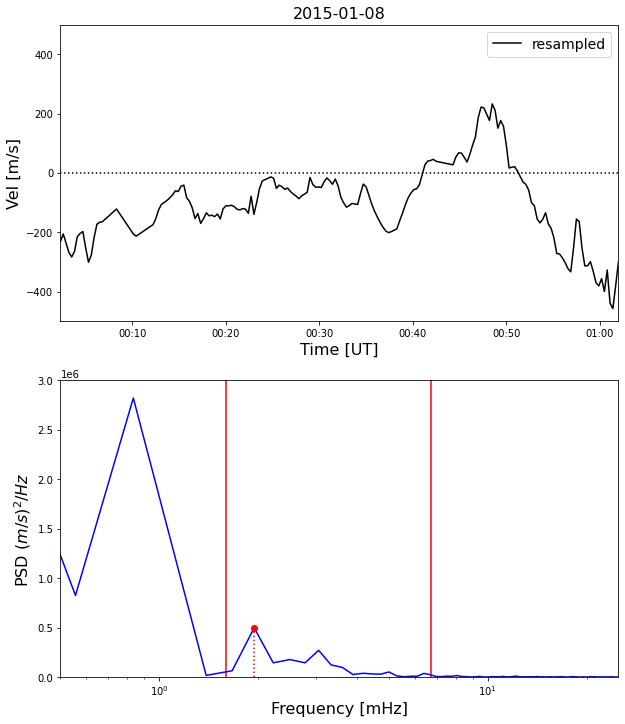

In [9]:
fig, (ax,bx)  = plt.subplots(nrows=2, ncols=1,figsize=(10,12))

plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16

start_time_plot = test_dt[0]
end_time_plot = test_dt[199]

myFmt = mdates.DateFormatter('%H:%M')
    
xlim = [start_time_plot,end_time_plot]
ylim=[-500,500]
ax.plot(test_dt,test_v,'k',label='resampled')
ax.hlines(0,xlim[0],xlim[1],linestyles='dotted',colors='k')
ax.set(xlim=xlim,ylim=ylim)
ax.set_title(start_time_plot.strftime("%Y-%m-%d"),fontsize=16)
ax.set_ylabel('Vel [m/s]',fontsize=16)
ax.set_xlabel('Time [UT]',fontsize=16)
ax.legend(fontsize=14)
ax.xaxis.set_major_formatter(myFmt)

xlim=[0.5,25]
ylim=[1,10000000]
ylim=[0,3000000]
bx.plot(fft_df1['frq']*1000,100*18.*fft_df1['amp']**2,'b-')
bx.plot(test[4],test[3], "o",color='r', markersize=6,linewidth=2)
#bx.hlines(results_half[1][0],1.78,1.78+0.343, color="r")
#bx.vlines(fft_df1['frq'][7]*1000,ylim[0],psd[7],linestyles='dotted',colors='r')
bx.vlines(test[4],ylim[0],test[3],linestyles='dotted',colors='r')
bx.vlines(1.6,ylim[0],ylim[1],linestyles='solid',colors='r')
bx.vlines(6.7,ylim[0],ylim[1],linestyles='solid',colors='r')
bx.set(xlim=xlim,ylim=ylim)
bx.set_xscale('log')
#bx.set_yscale('log')
#bx.vlines(x=2.7777777777777777,ymin=ylim[0],ymax=ylim[1],linestyles='dotted',colors='r')
bx.set_ylabel('PSD $(m/s)^2/Hz$',fontsize=16)
bx.set_xlabel('Frequency [mHz]',fontsize=16)
#bx.legend(fontsize=14)

plt.show()